In [1]:
# 1: Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
# 2: Loading the dataset
df = pd.read_csv("dataset_phishing.csv")

In [4]:
# Feature 1: Length of URL
df['length'] = df['url'].apply(len)

# Feature 2: Number of dots in URL
df['dots'] = df['url'].apply(lambda x: x.count('.'))

# Feature 3: Count of basic special characters
df['specialchars'] = df['url'].apply(lambda x: x.count('-') + x.count('@') + x.count('&') + x.count('%') + x.count('?') + x.count('='))

# Feature 4: Check if 'https' is present
df['http'] = df['url'].apply(lambda x: 1 if 'https' in x else 0)

# Feature 5: Check if the URL contains numbers and dots in domain (very basic IP pattern)
def feature(url):
    parts = url.split('/')
    if len(parts) > 2:
        domain = parts[2]
        return 1 if all(c.isdigit() or c == '.' for c in domain) and domain.count('.') == 3 else 0
    return 0

df['contains_ip'] = df['url'].apply(feature)

# Display the first few rows to verify
df[['url', 'length', 'dots', 'specialchars', 'http', 'contains_ip']].head(10)


,url,length,dots,specialchars,http,contains_ip
0,http://www.crestonwood.com/router.php,37,3,0,0,0
1,http://shadetreetechnology.com/V4/validation/a...,77,1,0,0,0
2,https://support-appleld.com.secureupdate.duila...,126,4,7,1,0
3,http://rgipt.ac.in,18,2,0,0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,55,2,2,0,0
5,http://appleid.apple.com-app.es/,32,3,1,0,0
6,http://www.mutuo.it,19,2,0,0,0
7,http://www.shadetreetechnology.com/V4/validati...,81,2,0,0,0
8,http://vamoaestudiarmedicina.blogspot.com/,42,2,0,0,0
9,https://parade.com/425836/joshwigler/the-amazi...,104,1,10,1,0


C:\Users\DELL\AppData\Local\Temp\ipykernel_25532\120349715.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


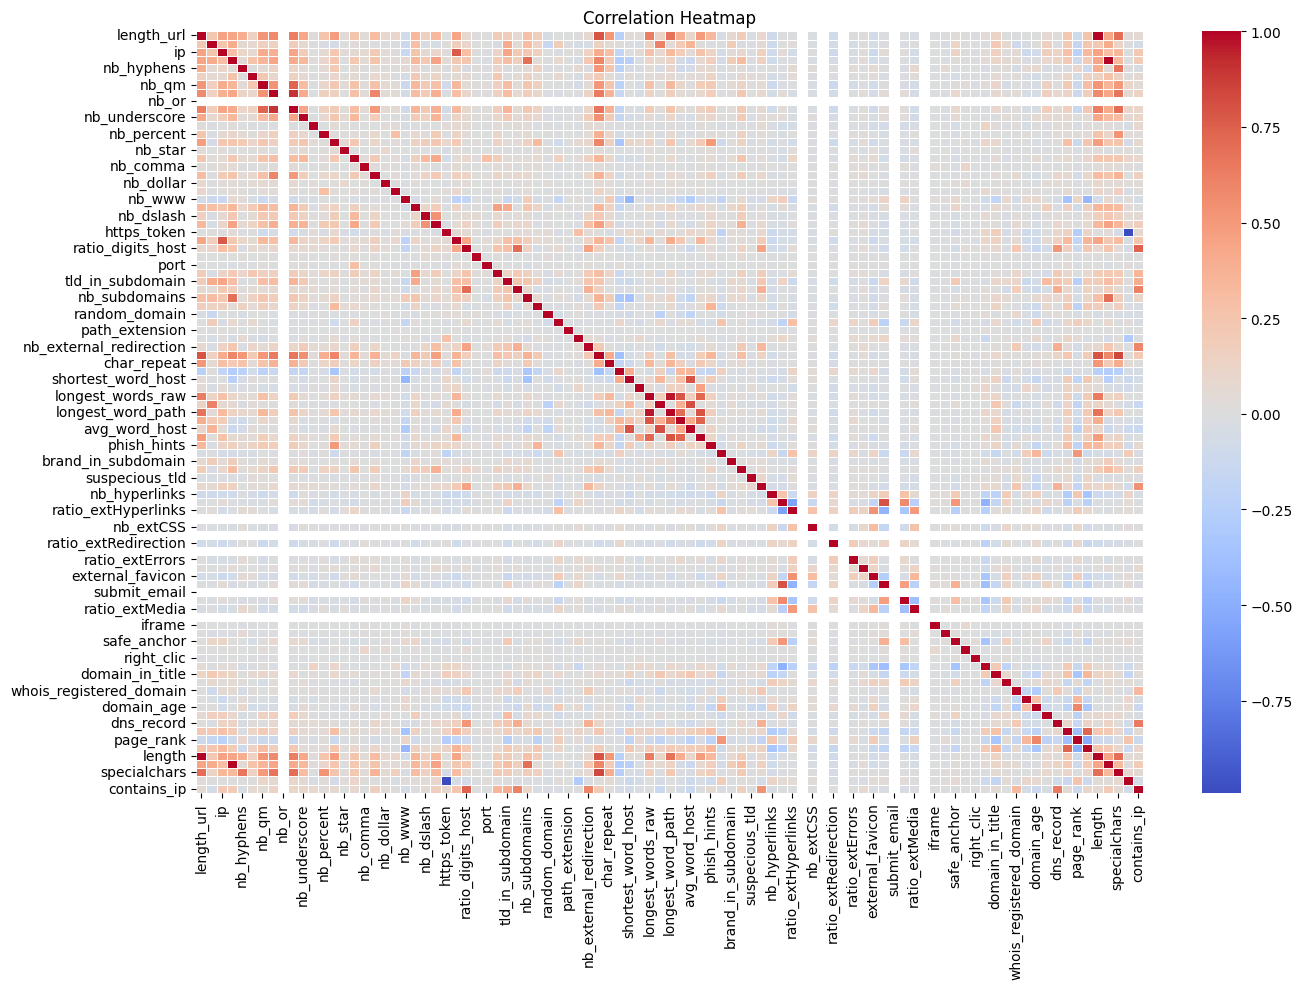

In [5]:
# Create correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


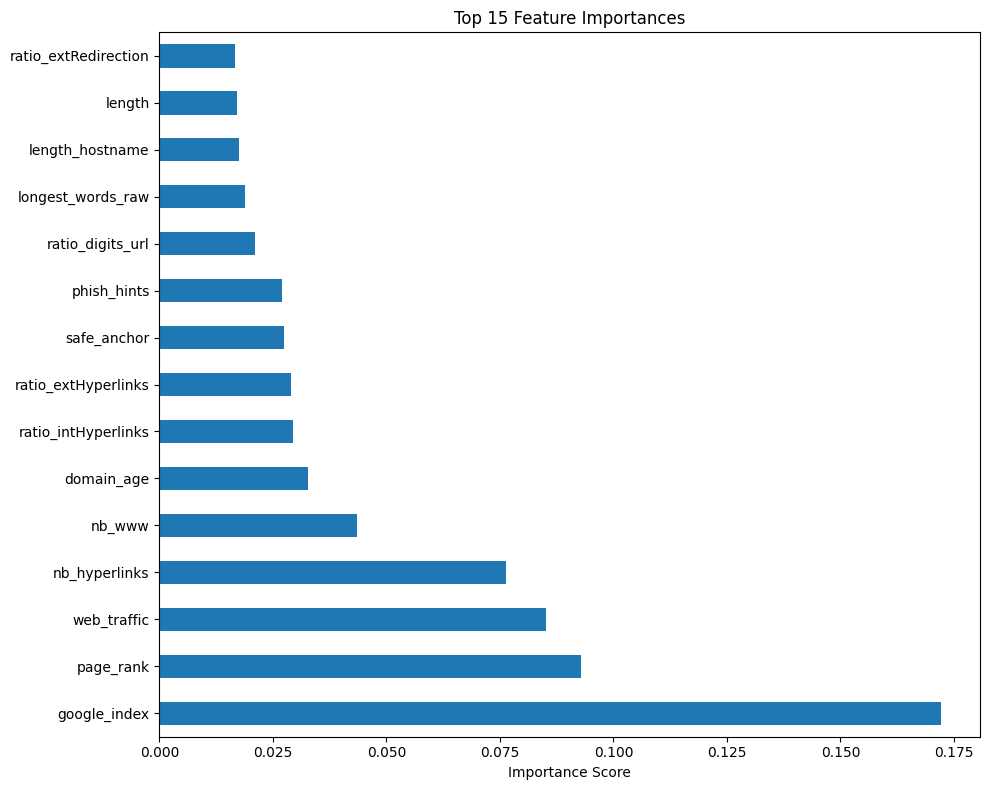

In [ ]:
# Prepare data
X = df.drop(['status', 'url'], axis=1, errors='ignore')
y = df['status']

# Train Random Forest model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Get and plot feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(15).plot(kind='barh', figsize=(10, 8), title="Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()



In [35]:
# Define the list of special character features 
all_special_char_cols = [
    'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
    'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
    'nb_semicolumn', 'nb_dollar', 'nb_space'
]

# Select only available columns from df
available_special_chars = [col for col in all_special_char_cols if col in df.columns]

# Safely create engineered features 
if available_special_chars:
    df['special_char_ratio'] = df[available_special_chars].sum(axis=1) / df['length_url']
else:
    df['special_char_ratio'] = 0  # or drop this if not wanted

# Digit-to-length ratio (already present as 'ratio_digits_url')
df['digit_url_ratio'] = df['ratio_digits_url'] if 'ratio_digits_url' in df.columns else 0

# Word length variance
word_cols = ['longest_words_raw', 'shortest_words_raw', 'avg_words_raw']
existing_word_cols = [col for col in word_cols if col in df.columns]
df['word_length_var'] = df[existing_word_cols].std(axis=1) if len(existing_word_cols) >= 2 else 0

# Final selected features 
selected_features = [
    col for col in [
        'length_url',
        'nb_dots',
        'http',
        'prefix_suffix',
        'random_domain',
        'shortening_service',
        'char_repeat',
        'domain_in_brand',
        'suspecious_tld',
        'web_traffic',
        'dns_record',
        'google_index',
        'page_rank',
        'domain_age',
        'domain_registration_length',
        'special_char_ratio',
        'digit_url_ratio',
        'word_length_var',
        'status'
    ] if col in df.columns  
]


df_final = df[selected_features]

# Output
print("Final dataset ready with shape:", df_final.shape)
display(df_final.head())


Final dataset ready with shape: (11430, 5)


,length_url,prefix_suffix,special_char_ratio,digit_url_ratio,word_length_var
0,37,0,0.000000,0,0
1,77,0,0.000000,0,0
2,126,1,0.015873,0,0
3,18,0,0.000000,0,0
4,55,0,0.036364,0,0


In [36]:
# Check if 'status' column is present
if 'status' not in df.columns:
    print("'status' column (target) is missing from the original dataset. Please ensure it is loaded.")
else:
    df_final['status'] = df['status']


'status' column (target) is missing from the original dataset. Please ensure it is loaded.


In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Load the dataset
df = pd.read_csv('dataset_phishing.csv')  

# Define useful special character columns 
all_special_char_cols = [
    'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
    'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
    'nb_semicolumn', 'nb_dollar', 'nb_space'
]
available_special_chars = [col for col in all_special_char_cols if col in df.columns]

#  Feature engineering
if available_special_chars:
    df['special_char_ratio'] = df[available_special_chars].sum(axis=1) / df['length_url']
else:
    df['special_char_ratio'] = 0

df['digit_url_ratio'] = df['ratio_digits_url'] if 'ratio_digits_url' in df.columns else 0

word_cols = ['longest_words_raw', 'shortest_words_raw', 'avg_words_raw']
existing_word_cols = [col for col in word_cols if col in df.columns]
df['word_length_var'] = df[existing_word_cols].std(axis=1) if len(existing_word_cols) >= 2 else 0

# Select final features + status 
final_cols = [
    'length_url', 'prefix_suffix', 'special_char_ratio',
    'digit_url_ratio', 'word_length_var', 'status'
]
df_final = df[[col for col in final_cols if col in df.columns]].copy()

# Checking if target column does exists
if 'status' not in df_final.columns:
    raise ValueError("'status' column is missing. Please verify your data source contains labels.")




In [41]:
# Save the updated dataset for modeling
df.to_csv("new_dataset.csv", index=False)
print("Refined dataset saved as 'new_dataset.csv'")


Refined dataset saved as 'new_dataset.csv'


In [43]:
data = pd.read_csv("new_dataset.csv")
print(data.shape)
print(data.info())
print(data.describe())

(11430, 92)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 92 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent         